# Time Series Forecasting of Traffic Patterns

## Dataset
This dataset includes hourly traffic of four junctions of a city. The sensors on each of these junctions were collecting data at different times, hence there are traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data.

This dataset contains 48,120 observations of the number of vehicles each hour in four different junctions:
1. DateTime
2. Juction
3. Vehicles
4. ID

Each data point consists of the DateTime of the measurement, the Junction number (1, 2, 3, or 4), the amount of vehicles, and an ID for each observation.


## Objective
Traffic congestion is rising in cities around the world. Contributing factors include expanding urban populations, aging infrastructure, inefficient and uncoordinated traffic signal timing and a lack of real-time data.

Traffic data and analytics company INRIX estimates that traffic congestion cost U.S. commuters $305 billion in 2017 due to wasted fuel, lost time and the increased cost of transporting goods through congested areas. Given the physical and financial limitations around building additional roads, cities must use new strategies and technologies to improve traffic conditions.

The objective is to predict the traffic over the next 4 months for each junction. The Prophet library will be used to forecast the amount of traffic over the next 4 months based on the previous traffic patterns. Time Series Analysis will be used to forecast the traffic. As an alterantive approach LSTM (Long-Short Term Memory) will also be used to forecast the traffic patterns.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings

sns.set(style="whitegrid")

## Exploratory Data Analysis

In [31]:
train_df = pd.read_csv(r"data/train_ML_IOT.csv")
train_df["DateTime"] = pd.to_datetime(train_df["DateTime"])
train_df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


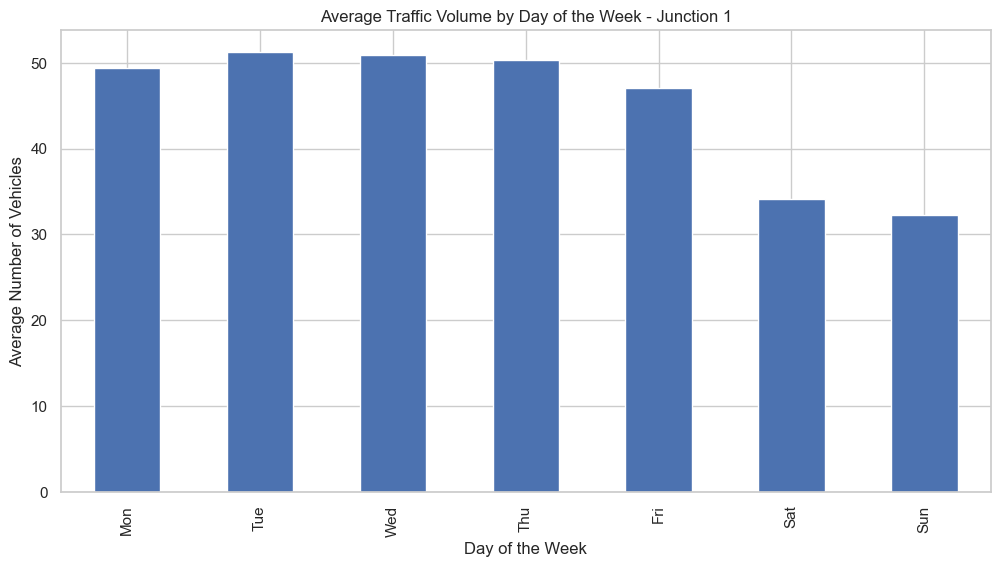

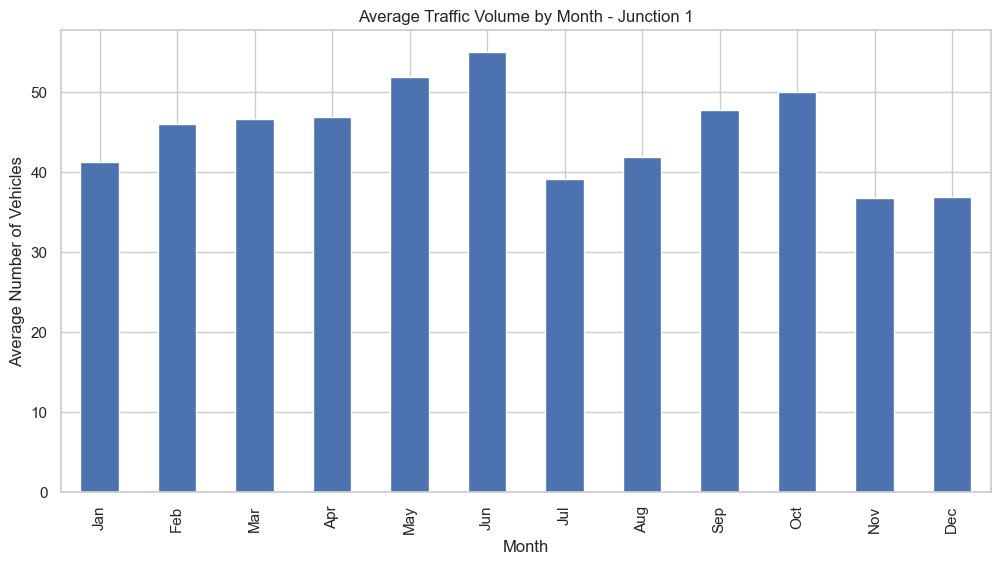

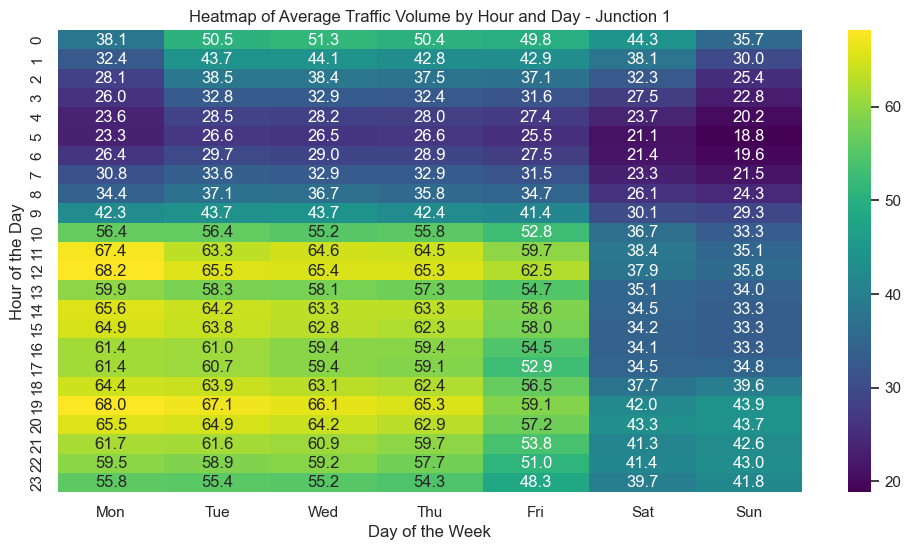

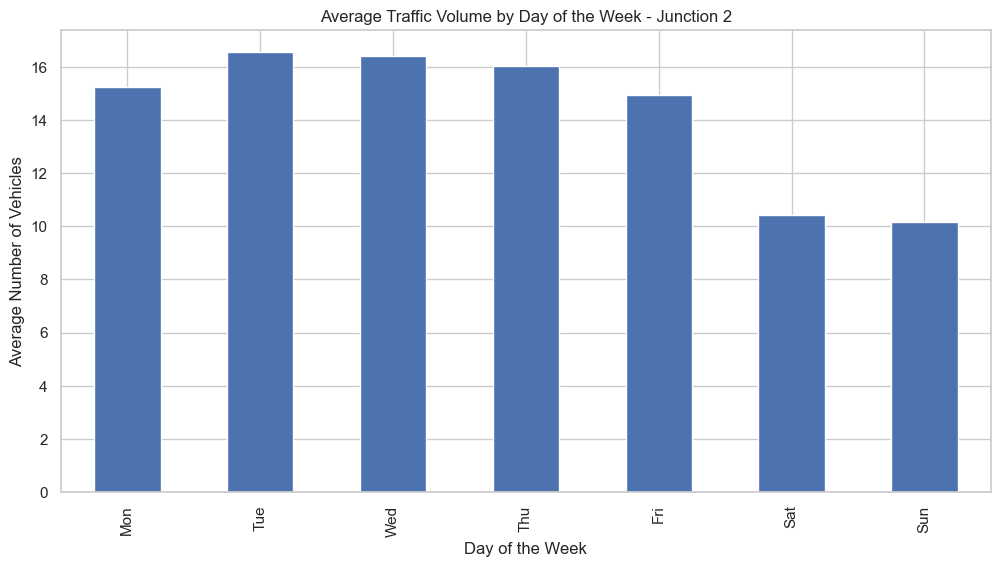

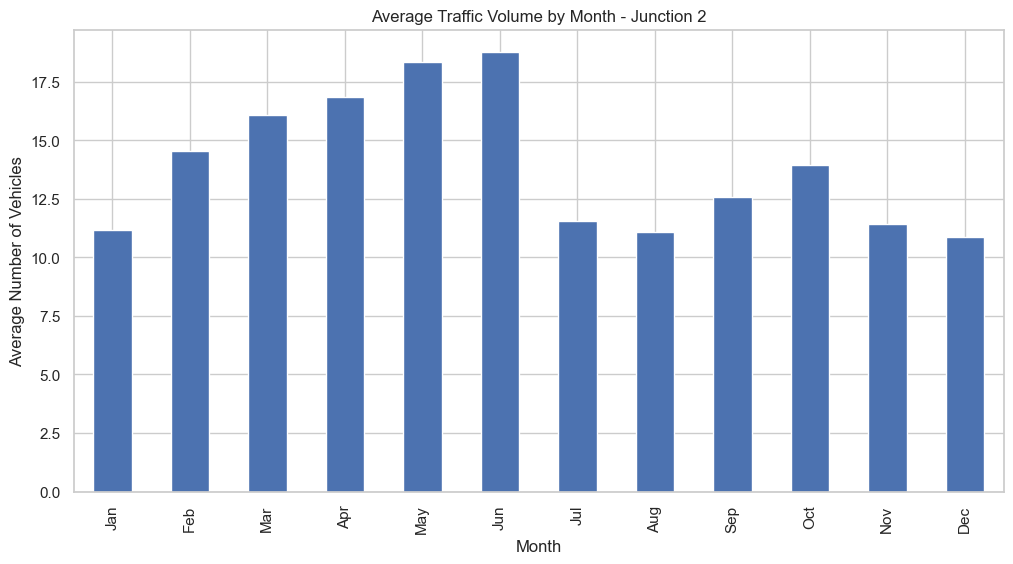

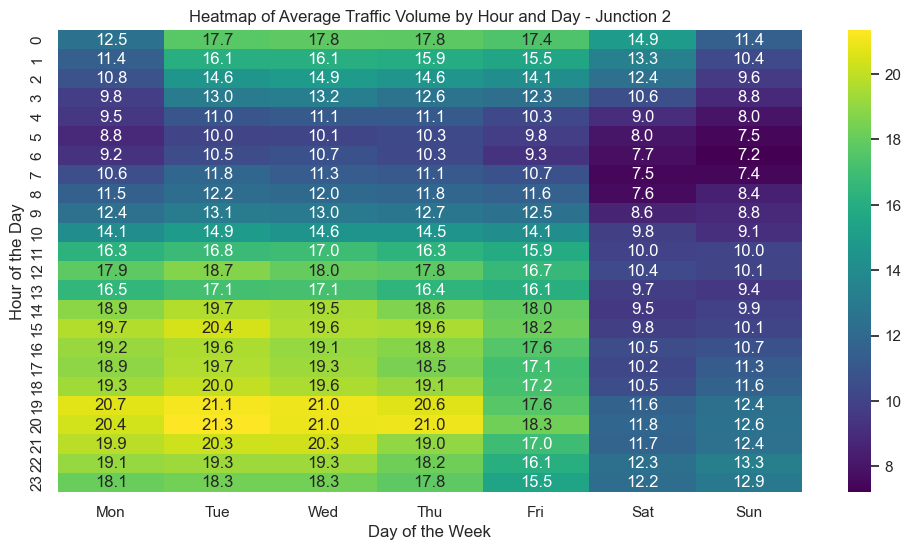

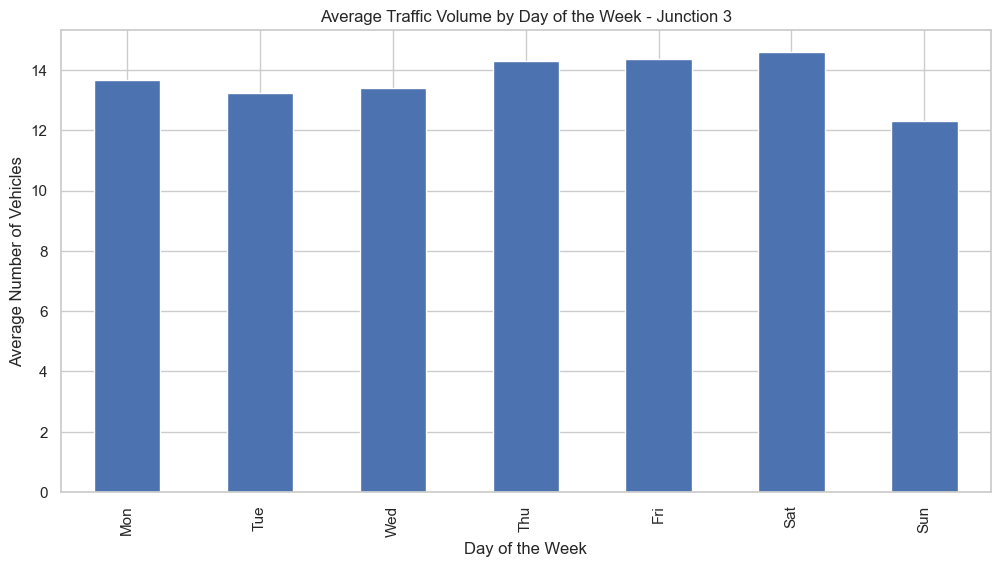

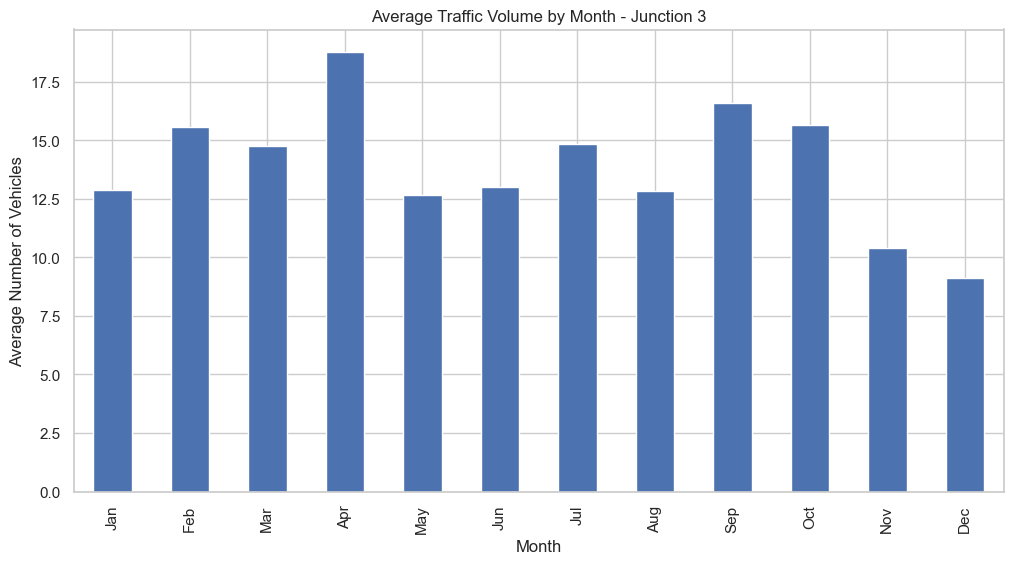

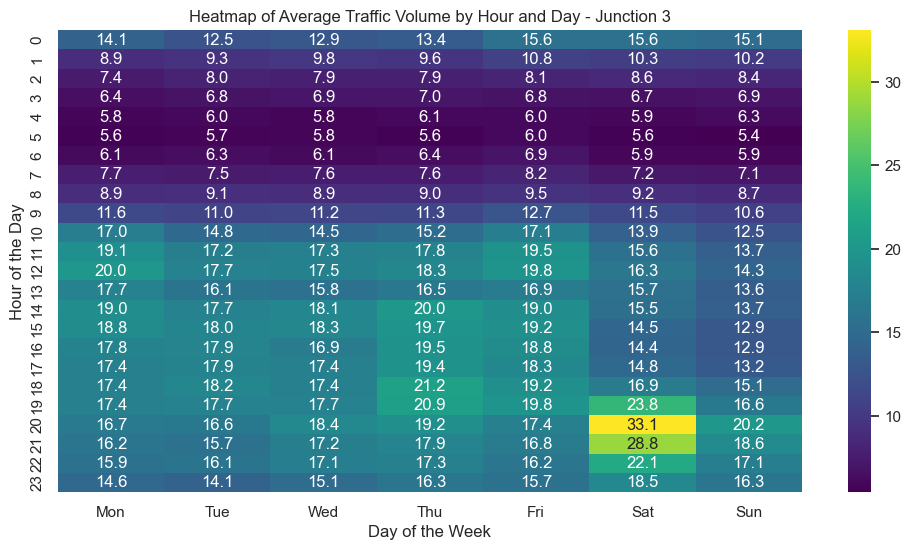

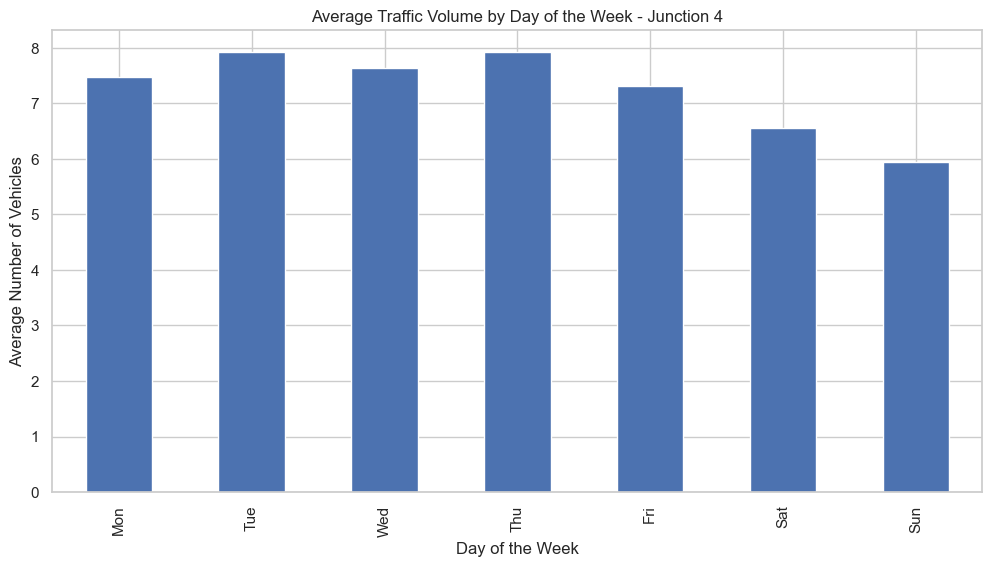

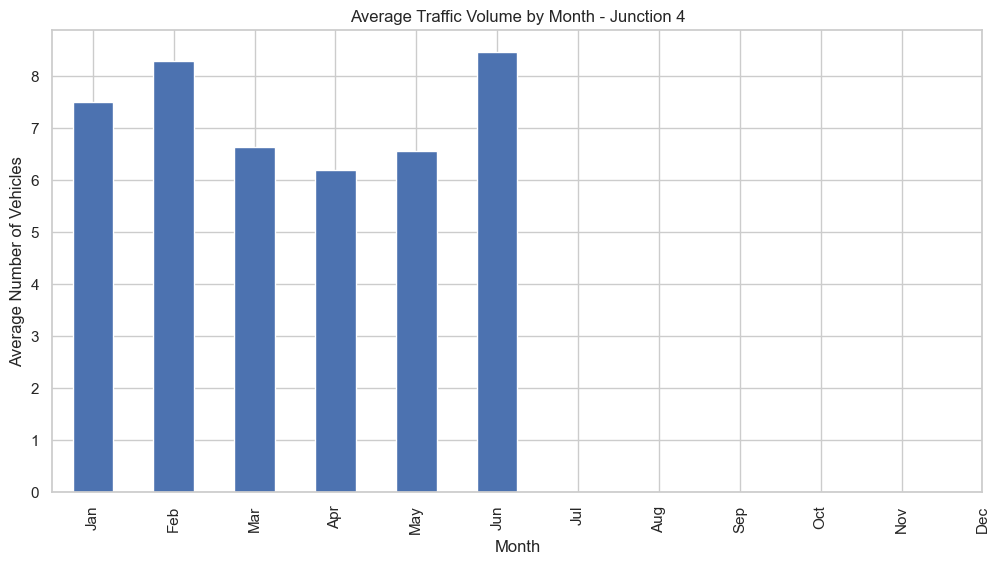

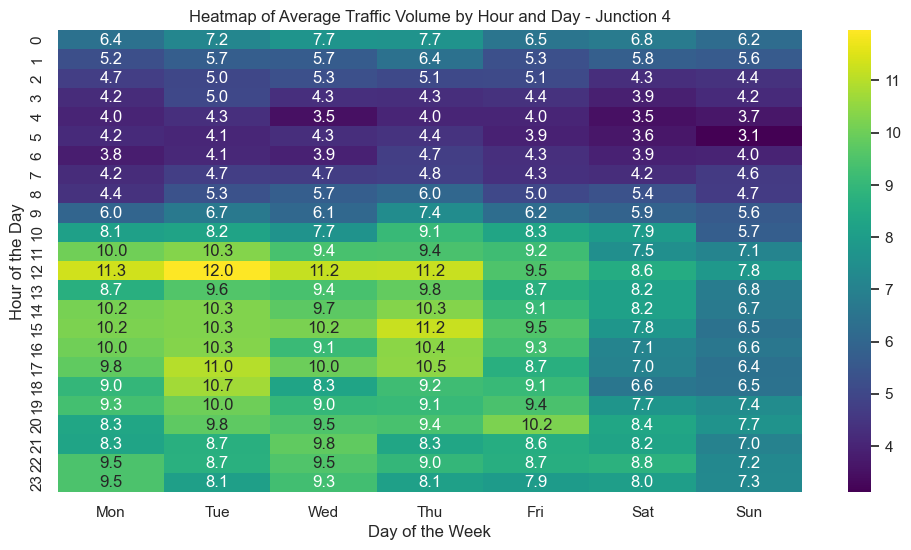

In [32]:
eda_df = train_df.copy()
eda_df["DateTime"] = pd.to_datetime(train_df["DateTime"], errors="coerce")

# Extract time-related features
eda_df["hour"] = eda_df["DateTime"].dt.hour
eda_df["day_of_week"] = eda_df["DateTime"].dt.dayofweek
eda_df["month"] = eda_df["DateTime"].dt.month
eda_df["year"] = eda_df["DateTime"].dt.year

for junction in (1, 2, 3, 4):
    df_junction = eda_df[eda_df["Junction"] == junction]
    plt.figure(figsize=(12, 6))

    df_junction.groupby("day_of_week")["Vehicles"].mean().plot(kind="bar")
    plt.title(f"Average Traffic Volume by Day of the Week - Junction {junction}")
    plt.xlabel("Day of the Week")
    plt.ylabel("Average Number of Vehicles")
    plt.xticks(
        ticks=np.arange(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    )
    plt.show()

    plt.figure(figsize=(12, 6))
    df_junction.groupby("month")["Vehicles"].mean().plot(kind="bar")
    plt.title(f"Average Traffic Volume by Month - Junction {junction}")
    plt.xlabel("Month")
    plt.ylabel("Average Number of Vehicles")
    plt.xticks(
        ticks=np.arange(0, 12),
        labels=[
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
    )
    plt.show()

    heatmap_data = (
        df_junction.groupby(["hour", "day_of_week"])["Vehicles"].mean().unstack()
    )
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".1f")
    plt.title(
        f"Heatmap of Average Traffic Volume by Hour and Day - Junction {junction}"
    )
    plt.xlabel("Day of the Week")
    plt.ylabel("Hour of the Day")
    plt.xticks(
        ticks=np.arange(7) + 0.5,
        labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    )
    plt.show()

Each juntion is converted into a column using a pivot table. Any NaN is converted to a 0.

In [33]:
train_pivot = train_df.pivot(index="DateTime", columns="Junction", values="Vehicles")
train_pivot = train_pivot.fillna(0)
train_pivot

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,9.0,7.0,2.0,0.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


The formatted data set is visualized to track the trend of the traffic over time. Junction 4 does not have any traffic 2017 which limits the available data.

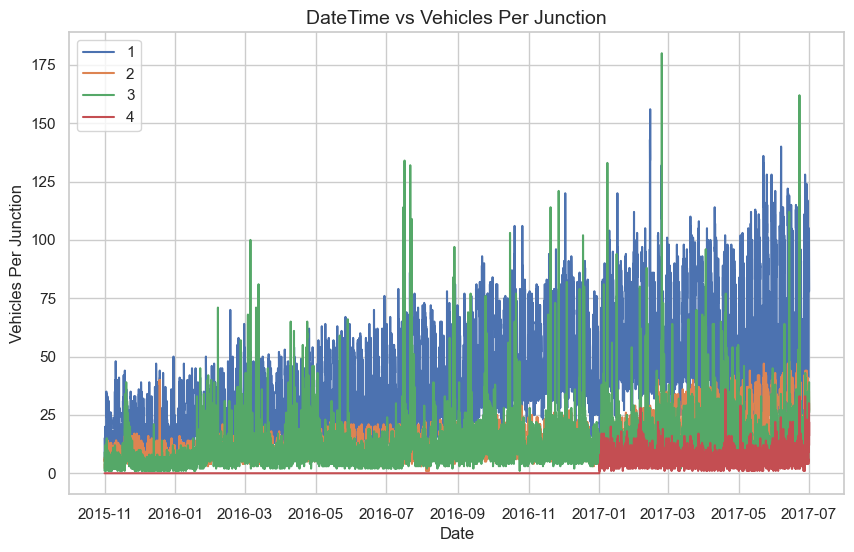

In [34]:
plt.figure(figsize=(10, 6))

for column in train_pivot.columns:
    sns.lineplot(data=train_pivot[column], label=column)

plt.title("DateTime vs Vehicles Per Junction", fontsize=14)
plt.ylabel("Vehicles Per Junction", fontsize=12)
plt.xlabel("Date", fontsize=12)

plt.legend()
plt.show()

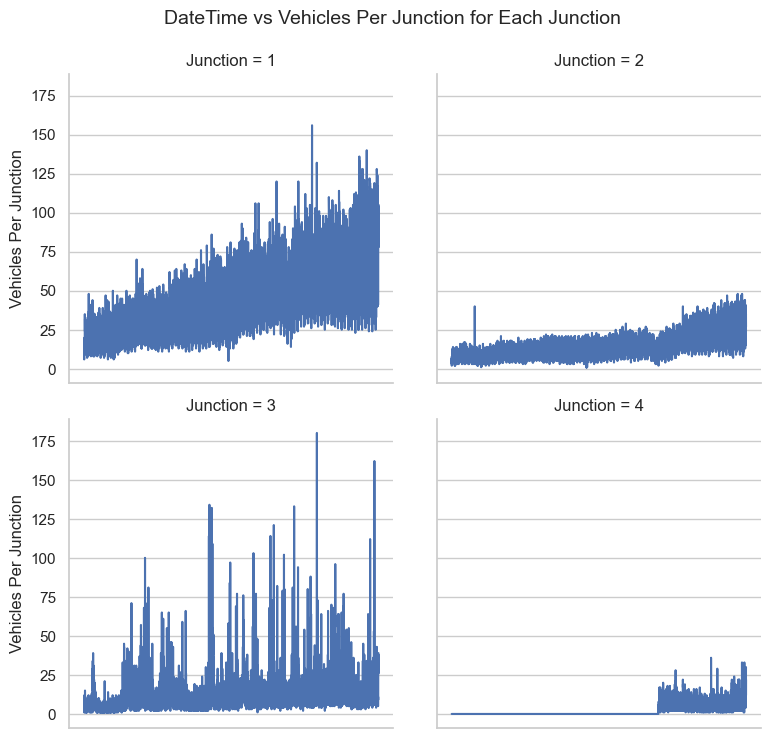

In [35]:
train_melted = train_pivot.reset_index().melt(
    id_vars="DateTime", var_name="Junction", value_name="Vehicles Per Junction"
)
train_melted = train_melted[train_melted["Junction"].isin((1, 2, 3, 4))]

g = sns.FacetGrid(train_melted, col="Junction", col_wrap=2, height=4)
g.map(sns.lineplot, "DateTime", "Vehicles Per Junction")
g.set(xticks=[], xlabel="")
g.fig.suptitle("DateTime vs Vehicles Per Junction for Each Junction", fontsize=14)
g.fig.subplots_adjust(top=0.9)

plt.show()

Plot of hourly data with yearly mean data. These plots show the traffic trend and the hourly fluctuations.

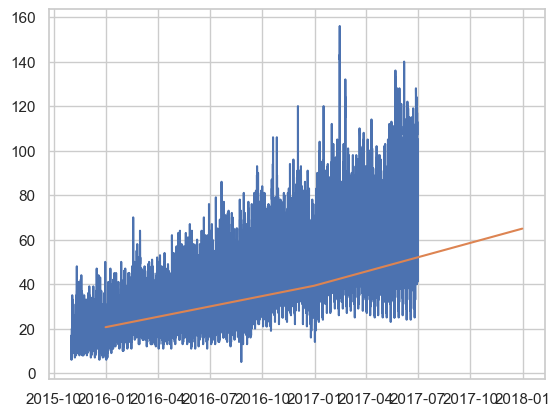

In [36]:
# resample to annual and plot each
annual_traffic_1 = train_pivot[1].resample("YE").mean()
plt.plot(train_pivot[1])
plt.plot(annual_traffic_1)
plt.grid(visible=True)

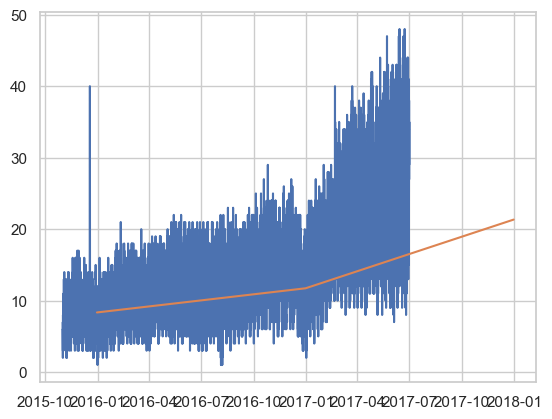

In [37]:
annual_traffic_2 = train_pivot[2].resample("YE").mean()
plt.plot(train_pivot[2])
plt.plot(annual_traffic_2)
plt.grid(visible=True)

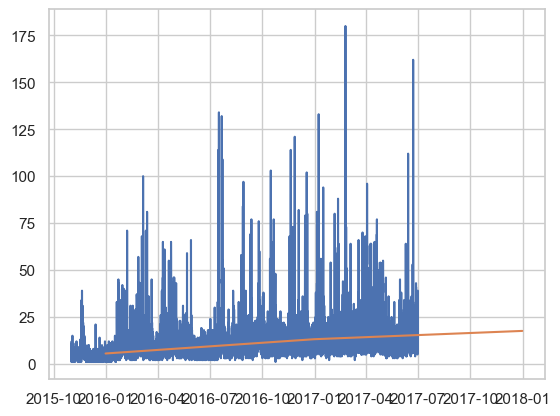

In [38]:
annual_traffic_3 = train_pivot[3].resample("YE").mean()
plt.plot(train_pivot[3])
plt.plot(annual_traffic_3)
plt.grid(visible=True)

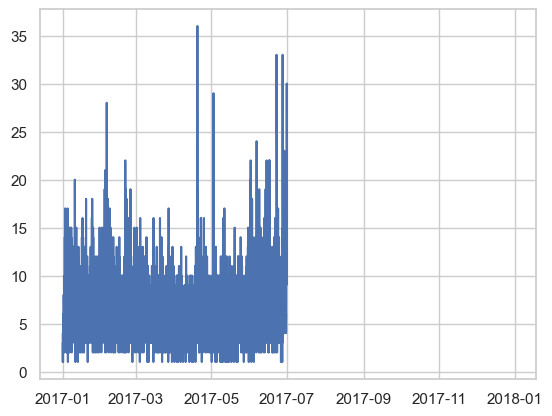

In [39]:
filtered = train_pivot[train_pivot[4].gt(0.0)]
annual_traffic_4 = filtered[4].resample("YE").mean()
plt.plot(filtered[4])
plt.plot(annual_traffic_4)
plt.grid(visible=True)

Violin plot to determine range and variance for each month.

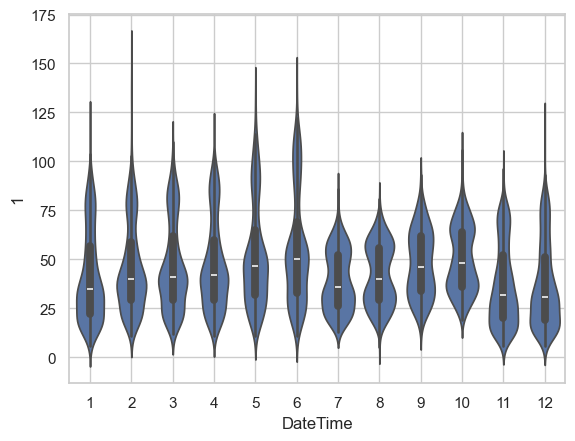

In [40]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[1])
plt.grid(visible=True)

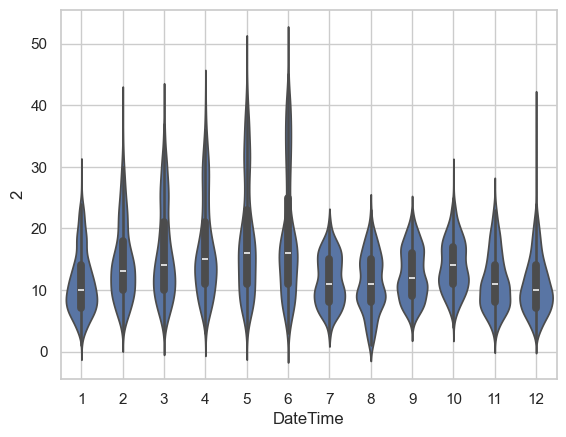

In [41]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[2])
plt.grid(visible=True)

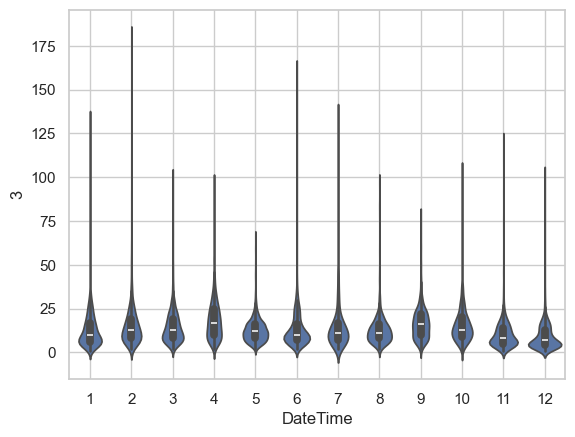

In [42]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[3])
plt.grid(visible=True)

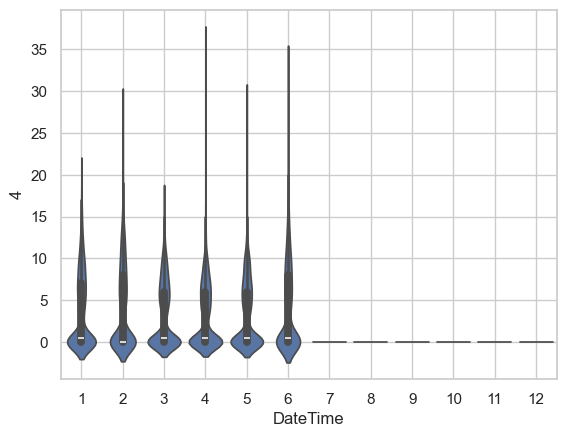

In [43]:
sns.violinplot(x=train_pivot.index.month, y=train_pivot[4])
plt.grid(visible=True)

## Dickey Fuller Test

The Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive (AR) time series model.

In [44]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts


def dftest(timeseries):
    dftest = ts.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid()
    plt.show(block=False)

Test Statistic         -7.148078e+00
p-value                 3.193843e-10
Lags Used               4.200000e+01
Observations Used       1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


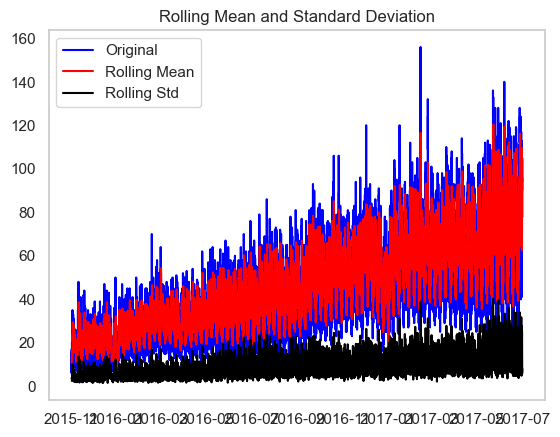

In [45]:
# run DFT on monthly
dftest(train_pivot[1])
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -8.041077e+00
p-value                 1.846368e-12
Lags Used               4.200000e+01
Observations Used       1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


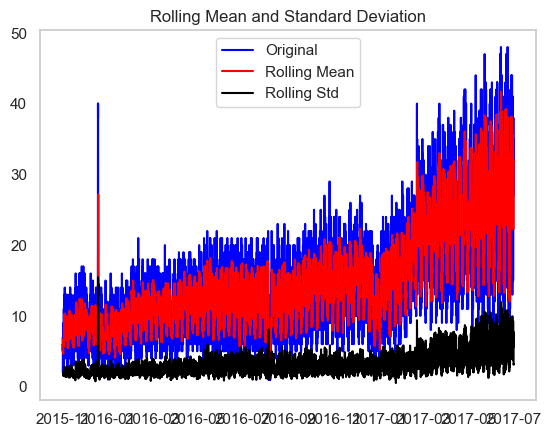

In [46]:
# run DFT on monthly
dftest(train_pivot[2])
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -8.236600e+00
p-value                 5.867296e-13
Lags Used               4.200000e+01
Observations Used       1.454900e+04
Critical Value (1%)    -3.430800e+00
Critical Value (5%)    -2.861739e+00
Critical Value (10%)   -2.566876e+00
dtype: float64


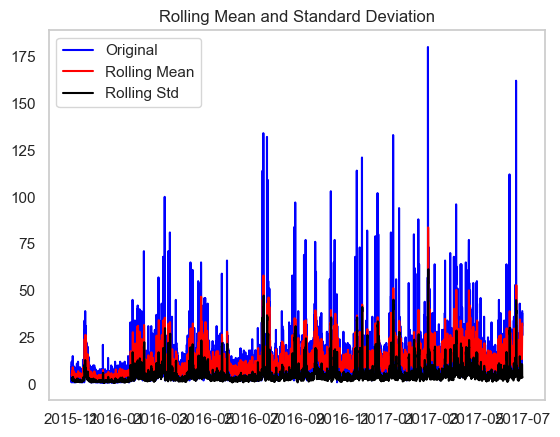

In [47]:
dftest(train_pivot[3])

Test Statistic         -6.726732e+00
p-value                 3.374875e-09
Lags Used               3.000000e+01
Observations Used       4.313000e+03
Critical Value (1%)    -3.431867e+00
Critical Value (5%)    -2.862210e+00
Critical Value (10%)   -2.567127e+00
dtype: float64


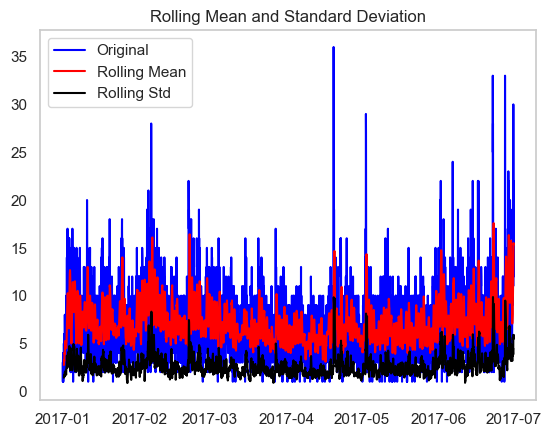

In [48]:
dftest(filtered[4])

The p-value allows us to *reject* a unit root (i.e. the data is stationary).

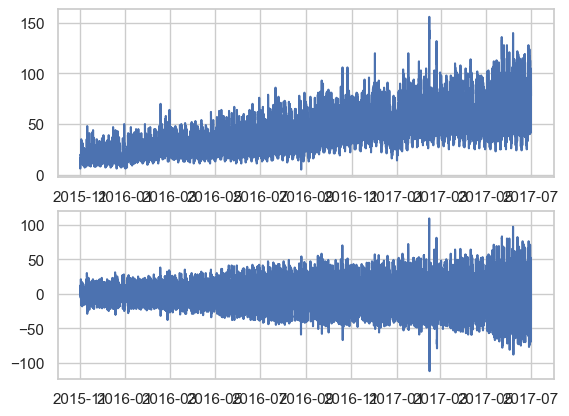

In [49]:
train_pivot["Junction 1 lag_12"] = train_pivot[1].shift(12)
train_pivot["Junction 1 seasonal_diff"] = (
    train_pivot[1] - train_pivot["Junction 1 lag_12"]
)

fig, axes = plt.subplots(2, 1)
axes[0].plot(train_pivot[1], label="original")
axes[1].plot(train_pivot["Junction 1 seasonal_diff"], label="seasonal diff")

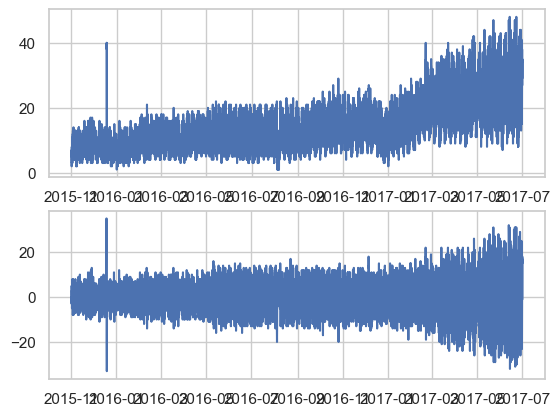

In [50]:
train_pivot["Junction 2 lag_12"] = train_pivot[2].shift(12)
train_pivot["Junction 2 seasonal_diff"] = (
    train_pivot[2] - train_pivot["Junction 2 lag_12"]
)

fig, axes = plt.subplots(2, 1)
axes[0].plot(train_pivot[2], label="original")
axes[1].plot(train_pivot["Junction 2 seasonal_diff"], label="seasonal diff")

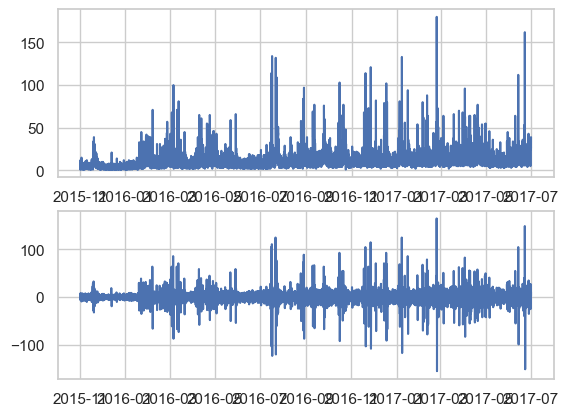

In [51]:
train_pivot["Junction 3 lag_12"] = train_pivot[3].shift(12)
train_pivot["Junction 3 seasonal_diff"] = (
    train_pivot[3] - train_pivot["Junction 3 lag_12"]
)

fig, axes = plt.subplots(2, 1)
axes[0].plot(train_pivot[3], label="original")
axes[1].plot(train_pivot["Junction 3 seasonal_diff"], label="seasonal diff")

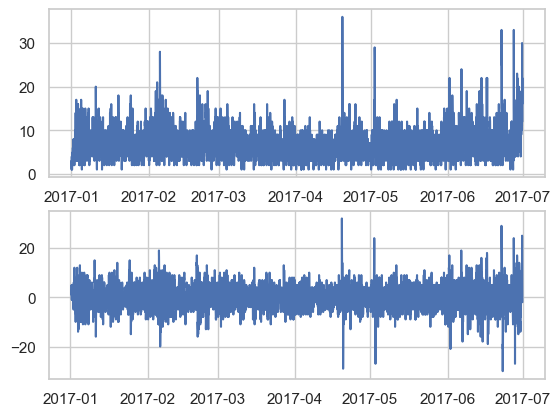

In [52]:
train_pivot["Junction 4 lag_12"] = filtered[4].shift(12)
train_pivot["Junction 4 seasonal_diff"] = filtered[4] - train_pivot["Junction 4 lag_12"]

fig, axes = plt.subplots(2, 1)
axes[0].plot(filtered[4], label="original")
axes[1].plot(train_pivot["Junction 4 seasonal_diff"], label="seasonal diff")

## Using Prophet to Forecast traffic data

In [53]:
# Function to forecast traffic
def forecast(junction, data, periods=2880):
    data_junction = data[data["Junction"] == junction].rename(
        columns={"DateTime": "ds", "Vehicles": "y"}
    )

    model = Prophet()
    model.fit(data_junction)
    future = model.make_future_dataframe(
        periods=periods, include_history=False, freq="h"
    )
    forecast = model.predict(future)

    forecast = forecast.drop(
        columns=[
            "daily",
            "daily_lower",
            "daily_upper",
            "additive_terms",
            "additive_terms_upper",
            "additive_terms_lower",
            "weekly",
            "weekly_lower",
            "weekly_upper",
            "multiplicative_terms",
            "multiplicative_terms_upper",
            "multiplicative_terms_lower",
        ]
    )

    fig = model.plot(forecast)
    xrange = fig.gca()
    xrange.set_xlim(pd.to_datetime(["2017-07-01", "2017-10-30"]))

    plt.title(f"Traffic Forecast For Junction {junction} In the Next 4 Months")
    plt.ylabel("Number of Vehicles")
    plt.xlabel("Time in Months")
    plt.show()

    return forecast

23:56:25 - cmdstanpy - INFO - Chain [1] start processing
23:56:30 - cmdstanpy - INFO - Chain [1] done processing


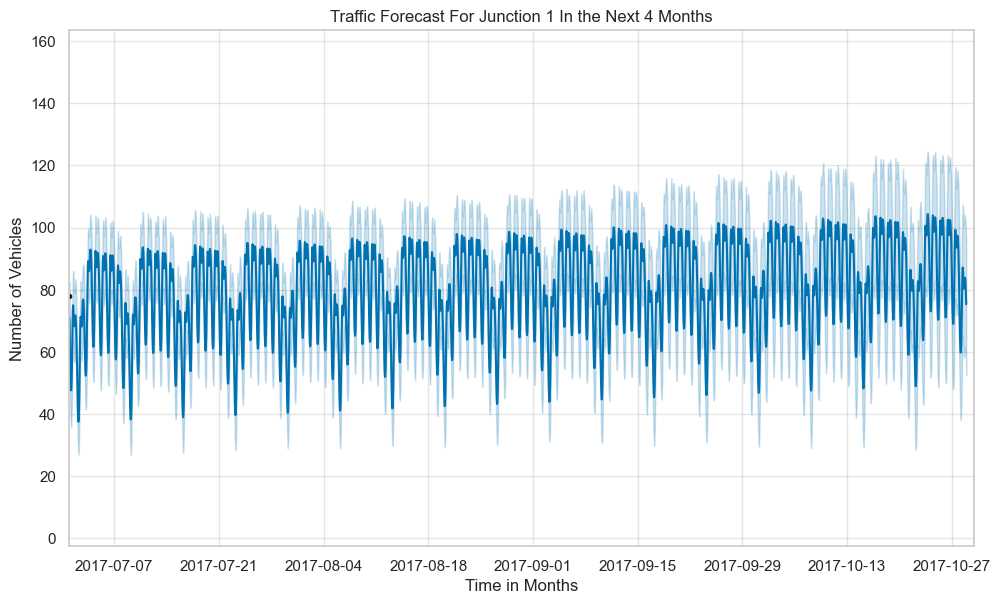

23:56:32 - cmdstanpy - INFO - Chain [1] start processing
23:56:37 - cmdstanpy - INFO - Chain [1] done processing


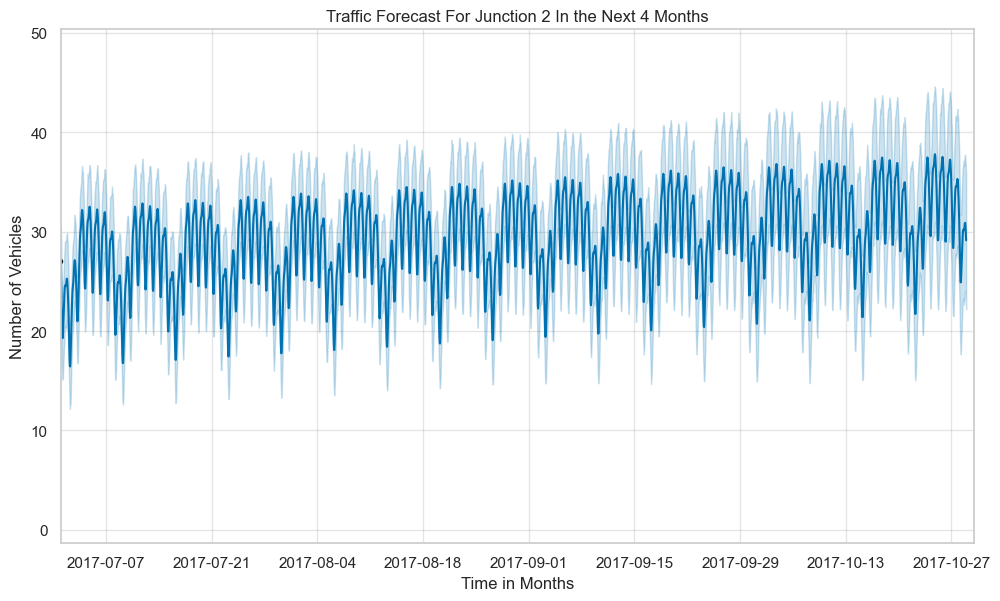

23:56:39 - cmdstanpy - INFO - Chain [1] start processing
23:56:44 - cmdstanpy - INFO - Chain [1] done processing


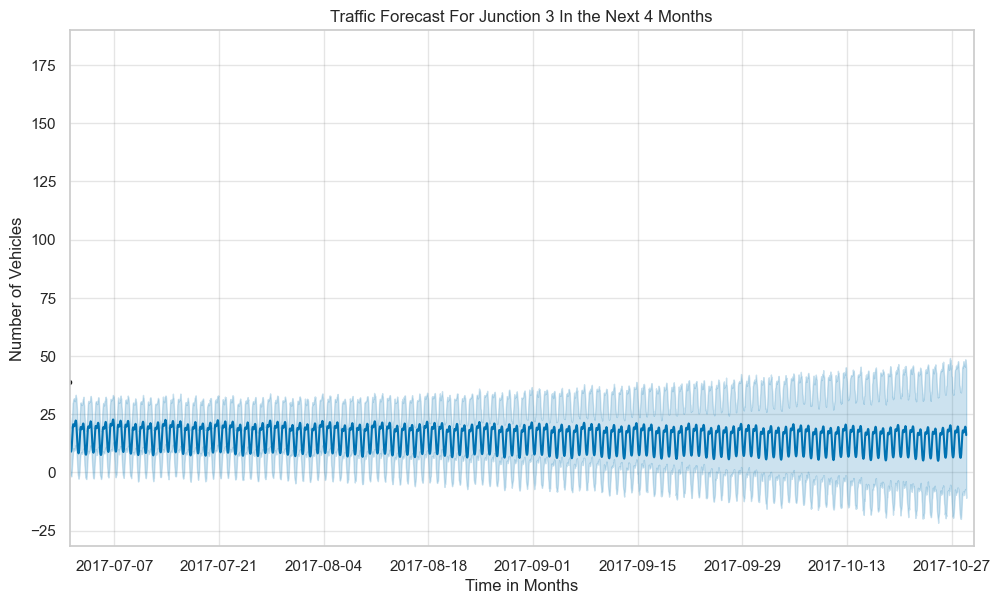

23:56:45 - cmdstanpy - INFO - Chain [1] start processing
23:56:45 - cmdstanpy - INFO - Chain [1] done processing


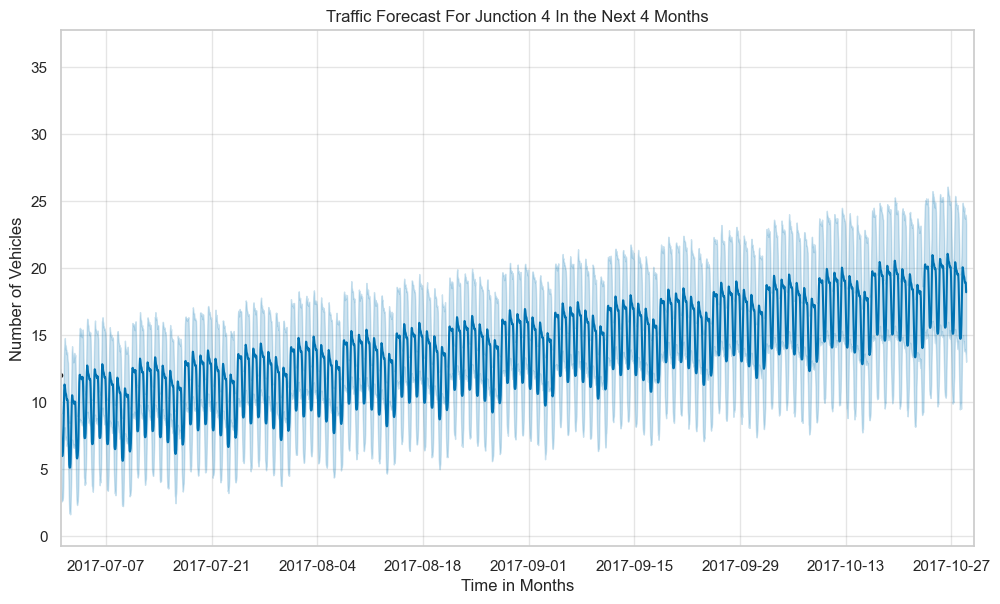

In [54]:
warnings.filterwarnings("ignore")
forecasts = {}
for junction in (1, 2, 3, 4):
    forecasts[junction] = forecast(junction, train_df, 2880)

## Measure Accuracy of Forecast

In [55]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

for junction in (1, 2, 3, 4):
    print(
        f"Junction {junction} MSE: {mean_squared_error(y_true=train_pivot[junction].tail(2880).values, y_pred=forecasts[junction]['yhat'].values)}"
    )
    print(
        f"Junction {junction} R2 Score: {r2_score(y_true=train_pivot[junction].tail(2880).values, y_pred=forecasts[junction]['yhat'].values)}"
    )
    print(
        f"Junction {junction} MAE: {mean_absolute_error(y_true=train_pivot[junction].tail(2880).values, y_pred=forecasts[junction]['yhat'].values)}"
    )

    print()

Junction 1 MSE: 413.07353228476194
Junction 1 R2 Score: 0.2651069924124628
Junction 1 MAE: 16.510219753238555

Junction 2 MSE: 71.9282506831706
Junction 2 R2 Score: -0.04745710212457288
Junction 2 MAE: 6.9252608114862095

Junction 3 MSE: 76.56882428091646
Junction 3 R2 Score: 0.3001685671459411
Junction 3 MAE: 5.06770126186523

Junction 4 MSE: 59.386186731136995
Junction 4 R2 Score: -3.937451802157131
Junction 4 MAE: 7.071925813457201



## LSTM to forecast data

Epoch 1/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 0.0070
Epoch 2/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - loss: 0.0013
Epoch 3/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - loss: 0.0011
Epoch 4/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 0.0010
Epoch 5/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - loss: 9.7944e-04
364/364 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


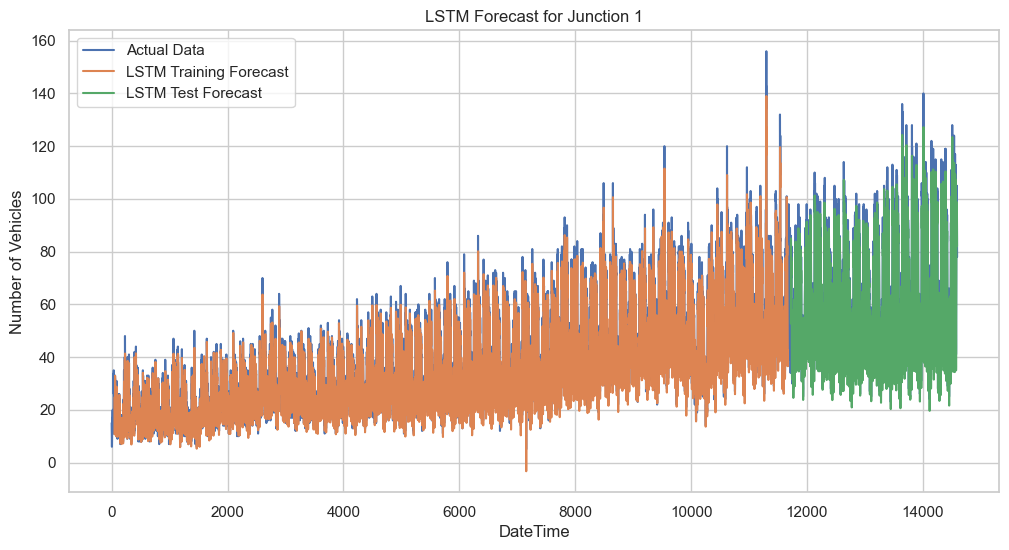

Train MSE: 23.060565118521254
Train MAE: 3.383299163186952
Train R²: 0.9374543670299657
Train MAPE: 0.09286247114980974
Test MSE: 46.25633091050045
Test MAE: 5.003529127964987
Test R²: 0.9177887579535882
Test MAPE: 0.07654732265906895
Epoch 1/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 0.0059
Epoch 2/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.0028
Epoch 3/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0026
Epoch 4/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.0026
Epoch 5/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.0026
364/364 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


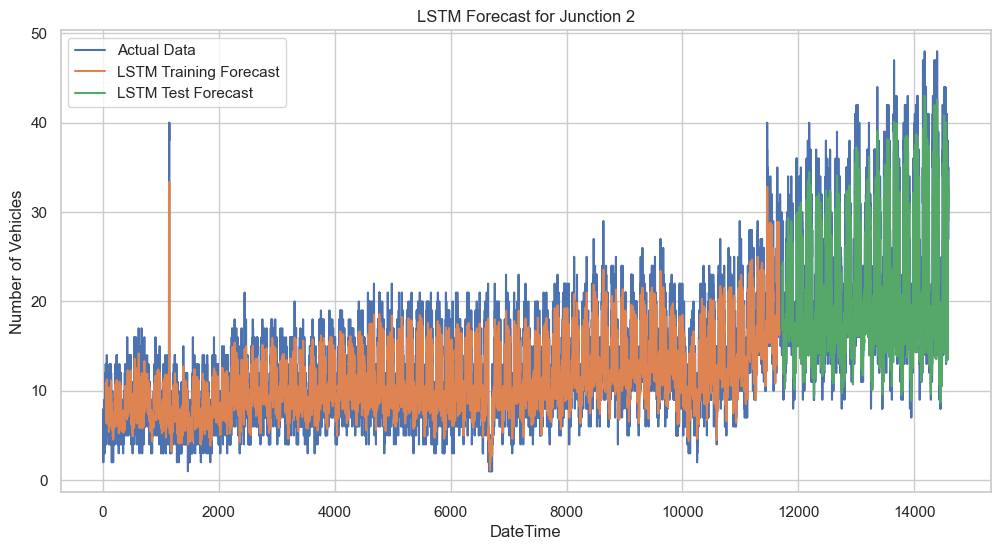

Train MSE: 5.475371743936235
Train MAE: 1.8491528621334417
Train R²: 0.7676373481018581
Train MAPE: 0.18426832536694124
Test MSE: 12.20356455984038
Test MAE: 2.7237163414107797
Test R²: 0.8225495373394988
Test MAPE: 0.11872358588858303
Epoch 1/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 0.0019
Epoch 2/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 9.1375e-04
Epoch 3/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 9.1470e-04
Epoch 4/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 9.2183e-04
Epoch 5/5
727/727 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 9.0005e-04
364/364 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


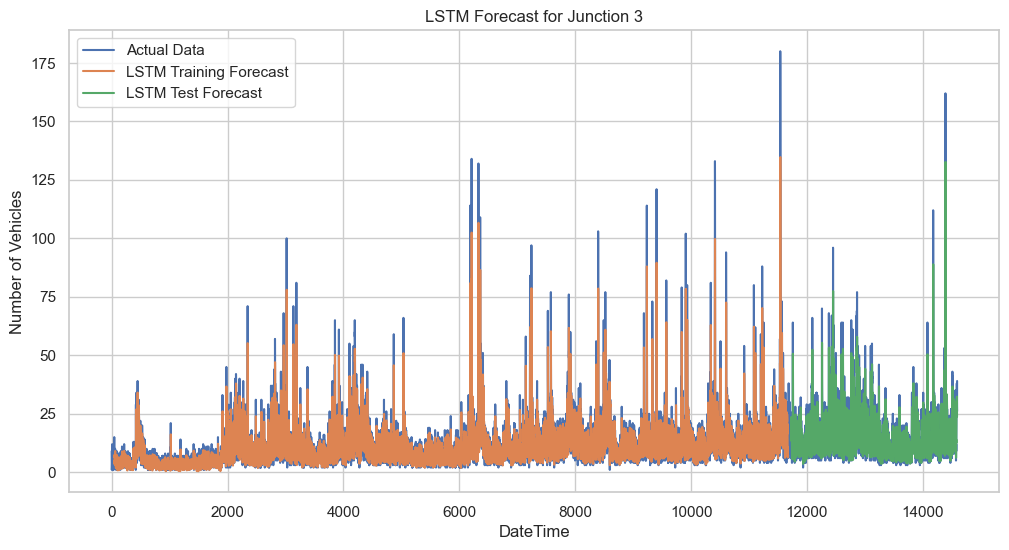

Train MSE: 27.989931054468908
Train MAE: 2.884986746887031
Train R²: 0.7321881337566901
Train MAPE: 0.27400107551144415
Test MSE: 35.37615151695844
Test MAE: 3.230061811686393
Test R²: 0.676895600268735
Test MAPE: 0.19390874641720507
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0100
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0053
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0060
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0049
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0050
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


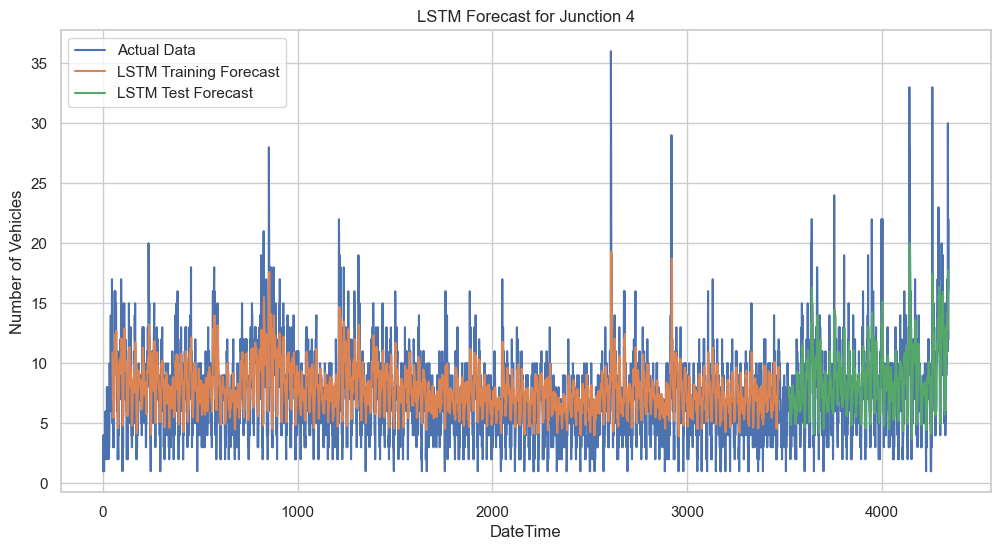

Train MSE: 6.2915334864251
Train MAE: 1.9567622511413316
Train R²: 0.4116543959221439
Train MAPE: 0.42590716857345495
Test MSE: 9.23554931577431
Test MAE: 2.201881975953172
Test R²: 0.5014856041800627
Test MAPE: 0.3768565984805361


In [56]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)

warnings.filterwarnings("ignore")

def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i : (i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)


lstm_df = train_df.copy()
lstm_df["DateTime"] = pd.to_datetime(lstm_df["DateTime"], errors="coerce")

lstm_df = lstm_df.set_index("DateTime")
scaler = MinMaxScaler(feature_range=(0, 1))

for junction in (1, 2, 3, 4):
    df_junction = lstm_df[lstm_df["Junction"] == junction]["Vehicles"]

    df_junction_scaled = scaler.fit_transform(df_junction.values.reshape(-1, 1))

    # Split data into training and testing sets
    train_size = int(len(df_junction_scaled) * 0.8)
    train, test = df_junction_scaled[:train_size], df_junction_scaled[train_size:]

    look_back = 48
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Train the model
    model.fit(X_train, y_train, batch_size=16, epochs=5)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])

    # Create a new dataframe to align the predictions with the dates
    train_predict_plot = np.empty_like(df_junction_scaled)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back : len(train_predict) + look_back, :] = train_predict

    test_predict_plot = np.empty_like(df_junction_scaled)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[
        len(train_predict) + (look_back * 2) + 1 : len(df_junction_scaled) - 1, :
    ] = test_predict

    # Plot LSTM forecast
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(df_junction_scaled), label="Actual Data")
    plt.plot(train_predict_plot, label="LSTM Training Forecast")
    plt.plot(test_predict_plot, label="LSTM Test Forecast")
    plt.title(f"LSTM Forecast for Junction {junction}")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

    # Performance evaluation
    train_mse = mean_squared_error(y_train[0], train_predict)
    train_mae = mean_absolute_error(y_train[0], train_predict)
    test_mse = mean_squared_error(y_test[0], test_predict)
    test_mae = mean_absolute_error(y_test[0], test_predict)

    # Calculate R² score and MAPE for additional accuracy evaluation
    train_r2 = r2_score(y_train[0], train_predict)
    test_r2 = r2_score(y_test[0], test_predict)
    train_mape = mean_absolute_percentage_error(y_train[0], train_predict)
    test_mape = mean_absolute_percentage_error(y_test[0], test_predict)

    print(f"Train MSE: {train_mse}")
    print(f"Train MAE: {train_mae}")
    print(f"Train R²: {train_r2}")
    print(f"Train MAPE: {train_mape}")
    print(f"Test MSE: {test_mse}")
    print(f"Test MAE: {test_mae}")
    print(f"Test R²: {test_r2}")
    print(f"Test MAPE: {test_mape}")

## Summary

The LSTM model is able to forecast the data better than the Prophet model. With additional information like major holidays in the area, major events, and weather data the accuray of the Prophet model could be improved. The LSTM model is better able to find these patterns within the data but it also has the ability to overfit the data. The results above are using only 5 epochs which does seem to find the minimum training loss without the risk of overfitting. Comparing the LSTM training and testing results it also shows the model does not appear to be under or over fitting the data. The LSTM model could benefit with some additional parameter tuning, modifying the amount of back data is fed to the model, the number of epochs, and the batch size could all be evaluate further.

Some key findings of the data is Junctions 1, 2, 4 are busiest mid week while Junction 3 is busiest towards the end of the week (Thursday, Friday, and Saturday). There is some variations in between each Junction and the monthly average traffic.

For the Prophet model the prediction is most accurate for Junction 4 and least accurate for Junction 1. The LSTM model is much more accurate for all Junctions compared to the Prophey model.

The LSTM model forecasts Junction 1 will continue to increase in traffic, Junction 2 will significantly increase in traffic, Junction 3 will not show much change in traffic, Junction 4, will show additional increase in traffic.




